This notebook allows easy use of my github repository to find conceptual direction in langguage models.

How to use:
* Sections _Importation_ and _Load Data_ are just used to setup the model and the datasets. It currently works well for gpt2 models.
* Section _Learning and Testing Hyperplanes_ allows you to test if we can extract a separating hyperplane for gender from the activations of the model.
* Section _Steer and Erasure_ allows you to test erasing and steering the model's notion of gender with various hyperparameters.
The notion of steering is different than in Turner's article. 
* Section _Continuation Modifications_ allows to generate continuations of a sentence when the concept is erased, to see if the gender changes.

# Installation



Import GPT2-xl with the available RAM. Setup and import all important packages.\

In [1]:
gpt_small = True # True for gpt2-small, False for gpt2-xl
import sys
in_colab = 'google.colab' in sys.modules

In [2]:
# import the useful libraries if you are working on google colab
if in_colab:
    !git clone https://github.com/leodana2000/finding_gender_direction.git
    !pip install transformers
    !pip install accelerate

In [3]:
if in_colab:
    sys.path.append("/content/finding_gender_direction")
else:
    PATH = "/finding_gender_direction/"
    sys.path.append(PATH)

from hyperplane_computation import utils
from hyperplane_computation.inference_time_modif import score
from hyperplane_computation.store_test_hyperplane import hyperplane_acc, storing_hyperplanes
from hyperplane_computation.continuation import continuate
from Data.data_type import DataStorage

import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

In [4]:
t.set_grad_enabled(False)

if gpt_small:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
  model = GPT2LMHeadModel.from_pretrained('gpt2')
else:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-xl')
  model = GPT2LMHeadModel.from_pretrained('gpt2-xl', device_map="auto", offload_folder="offload", offload_state_dict=True)

model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
if t.cuda.is_available():
    device = t.device('cuda')
else:
    device = t.device('cpu')

model.to(device)
tokenizer.pad_token = tokenizer.eos_token

dict = {
    'device': device,
    'model': model,
    'tokenizer': tokenizer,
}

# Load Data

We load below the training data and store it into a DataStorage object which facilitate batching, splitting into train-test sets, etc.

In [6]:
batch_size = 1024
rand_seed = 42
train_test_ratio = 0.85

if in_colab:
    D = pd.read_csv("finding_gender_direction/Data/Train_Data_v1.csv")
else:
    D = pd.read_csv("Data/Train_Data_v1.csv")

dataset = DataStorage(
    D,
    batch_size=batch_size,
    rand_seed=rand_seed,
    train_test_ratio=train_test_ratio,
)

We load below the test data. It is a batched list containing questions to answer, the gender of the true answer, as well as the target word that is gendered in the question.\
If the target appears several times in the question, only the last occurrence is the target.

In [7]:
if in_colab:
    Test = pd.read_csv("finding_gender_direction/Data/Test_Data.csv")
else:
    Test = pd.read_csv("Data/Test_Data.csv")

examples_A = Test[Test['data_num'] == 'a'][['question', 'bin', 'target']].values.tolist()
examples_B = Test[Test['data_num'] == 'b'][['question', 'bin', 'target']].values.tolist()
examples_C = Test[Test['data_num'] == 'c'][['question', 'bin', 'target']].values.tolist()
examples_D = Test[Test['data_num'] == 'd'][['question', 'bin', 'target']].values.tolist()

# Since the test sets for names are much larger than for nouns, we select a subset of same size, and with the same parity.
examples_C = utils.select_rand(examples_C, len(examples_B), rand_seed)
examples_D = utils.select_rand(examples_D, len(examples_A), rand_seed)

examples_A = [list(row) for row in zip(*examples_A)]
examples_B = [list(row) for row in zip(*examples_B)]
examples_C = [list(row) for row in zip(*examples_C)]
examples_D = [list(row) for row in zip(*examples_D)]

examples = [examples_A, examples_B, examples_C, examples_D]
#example has shape [batch, [questions, bin_label, target]]

In [8]:
# list of tokens counted as "good" answers for each gender

male_words = ["he", "him", "his", "male", "son", "father", "boy"]
female_words = ["she", "her", "female", "daughter", "mother", "girl"]

# Create alternative tokens with upper case and space.
text_lists = [[],[]]
for m_word, f_word in zip(male_words, female_words):
    text_lists[0].append(m_word)
    text_lists[0].append(m_word[0].upper()+m_word[0:])
    text_lists[0].append(" "+m_word)
    text_lists[0].append(" "+m_word[0].upper()+m_word[0:])
    text_lists[1].append(f_word)
    text_lists[1].append(f_word[0].upper()+f_word[0:])
    text_lists[1].append(" "+f_word)
    text_lists[1].append(" "+f_word[0].upper()+f_word[0:])

token_lists = [tokenizer(text_list).input_ids for text_list in text_lists]

# Reduce to only one token.
token_lists = [[[token[0]] for token in token_lists[0]], [[token[0]] for token in token_lists[1]]]

# Learning and Testing Hyperplane

We learn the gender direction using the difference in mean (as implemented in _LEACE: Perfect linear concept erasure in closed form_), using a diff-mean quantile method (my theoretic improvement on LEACE), and using Logistic Regression as a baseline.\
We try both learning the full data, and splitting it into 85% training and 15% testing.\
On gpt2-xl, both cases are very similar:
* Layers 0-9 are almost completely linearly separable,
* From layer 10 on, accuracy drops for both the Leace methods (60%) and the LogReg methods (70%),
* We have a good generalization to out-of-ditribution data.



In [9]:
Learn = dataset.get_ex('learn', multi_dim=False)

# Learn the estimators on the attention
eraser_mean, eraser_quantile, eraser_probe = storing_hyperplanes(Learn, post_layer_norm=True, learn_probe=True, **dict)

Train = dataset.get_ex('train', multi_dim=False)

# Learn the estimators on the attention
eraser_mean_train, eraser_quantile_train, eraser_probe_train = storing_hyperplanes(Train, post_layer_norm=True, learn_probe=True, **dict)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 12/12 [00:32<00:00,  2.75s/it]


In [10]:
metric_q = utils.probe_eval(eraser_quantile, **dict)
metric_m = utils.probe_eval(eraser_mean, **dict)
metric_p = utils.probe_eval(eraser_probe, **dict)

acc_data_1 = hyperplane_acc(Learn, [metric_q, metric_m, metric_p], **dict)

Test = dataset.get_ex('test', multi_dim=False)

metric_q = utils.probe_eval(eraser_quantile_train, **dict)
metric_m = utils.probe_eval(eraser_mean_train, **dict)
metric_p = utils.probe_eval(eraser_probe_train, **dict)

acc_data_2 = hyperplane_acc(Test, [metric_q, metric_m, metric_p], **dict)

100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


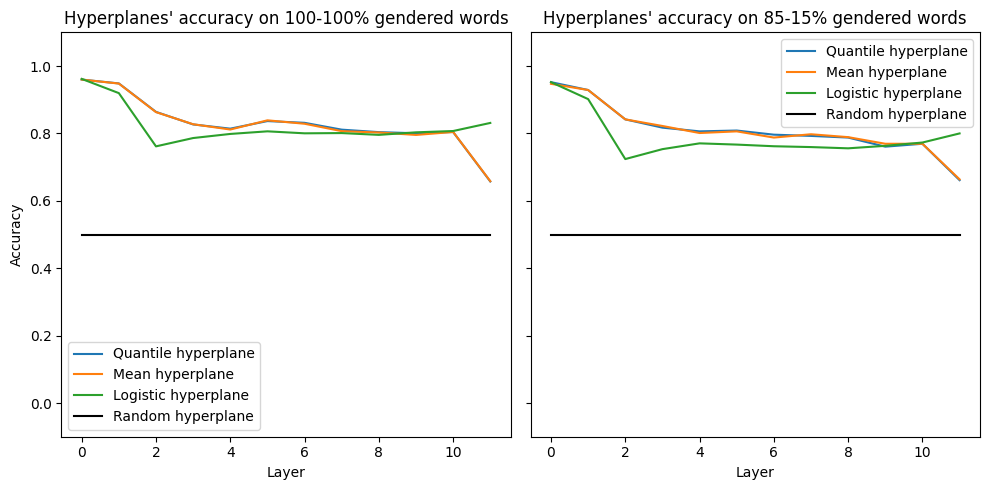

In [11]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex = True, sharey = True)

axes[0].plot(acc_data_1[0], label = 'Quantile hyperplane')
axes[0].plot(acc_data_1[1], label = 'Mean hyperplane')
axes[0].plot(acc_data_1[2], label = 'Logistic hyperplane')
axes[0].plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random hyperplane')
axes[0].set_title("Hyperplanes' accuracy on 100-100% gendered words")
axes[0].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(-0.1, 1.1)
axes[0].legend()

axes[1].plot(acc_data_2[0], label = 'Quantile hyperplane')
axes[1].plot(acc_data_2[1], label = 'Mean hyperplane')
axes[1].plot(acc_data_2[2], label = 'Logistic hyperplane')
axes[1].plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random hyperplane')
axes[1].set_title("Hyperplanes' accuracy on {}-{}% gendered words".format(int(100*train_test_ratio), int(100*(1-train_test_ratio))))
axes[1].set_xlabel("Layer")
axes[1].set_ylim(-0.1, 1.1)
axes[1].legend()

plt.tight_layout()
plt.show()

# Steer and Erasure

If you want to be sure that your questions have the right answer with a good probability, you can run this cell and look manually at each responses by the model.

In [12]:
# Visualise if the test examples have good probability / accuracy
prompts = examples_A
test_prompt = False

if test_prompt:
  tokenized_sentences = [tokenizer(prompt, return_tensors = 'pt')["input_ids"].to(device) for prompt in prompts]

  for tokenized_sentence, prompt in zip(tokenized_sentences, prompts):
    print(prompt)
    print(utils.show_proba(t.softmax(model(tokenized_sentence).logits[0, -1], dim = -1), nb_tokens = 5, decode = True, **dict))

In this section, run our erasure-steering algorithm. Given a question and a target to modify, we apply a transformation on the activations at each layer. More specifically, we run in parallel several experiments:
* one for each $\lambda$ (the steering hyperparameters)
* one for each set of layers (elements of *layer_list* and *layer_res_list*)

For each experiments (*exp*, $\lambda$), we intervene in the following way:
* for each elements in *layer_res_list[exp]*, we apply at the corresponding layer the $\lambda$-steering in the residual,
* for each elements in *layer_list[exp]*, we apply at the corresponding layer the $\lambda$-steering on the attention,

Let's now describe the base $\lambda$-steering method. Given and activation *act* and a d-dimensional plane (plane, diffmean, bias), we have:
* $\bar{act} = act - \lambda <plane|act-bias> diffmean$

Which is a diagonal projection on the plane, continuous on lambda. So, as $\lambda$ increases from 0 to 1, more concept should be erased. At $\lambda=1$ we shouldn't have any concept. From 1 to 2, we should swap the concept.\

Now for the $\lambda$-steering on the attention, what happens is more complicated. Basically, at *layer_list[exp]*, and at the stream which is targeted for that question, we intervene on the keys and values, but only after the attention module was computed at this stream and layer. Thus, there is no effect on the current stream, but latter streams at that layer will see modified keys and values. These keys and values are modified with the previous continuous projection.\

For more details, see XXX.

In [13]:
# We compute all of the leace fitters and erasers
nb_layers = len(model.transformer.h)
layer_list = [[i for i in range(0, nb_layers)]]
layer_res_list = [[]]
lbds = t.tensor([i/10 for i in range(0, 41, 1)], dtype=t.float32)

res_needed = len(layer_res_list[0]) > 0

In [14]:
Learn = dataset.get_ex('learn', multi_dim=True)

# Learning the estimators in the residual stream
flag = True
if flag:
  eraser_mean, eraser_quantile, _ = storing_hyperplanes(Learn, post_layer_norm=True, learn_probe=False, **dict)
  flag = False

if res_needed:
    eraser_mean_res, eraser_quantile_res, _ = storing_hyperplanes(Learn, post_layer_norm=False, learn_probe=False, **dict)
else:
    eraser_mean_res, eraser_quantile_res = None, None

100%|██████████| 12/12 [00:27<00:00,  2.29s/it]


In [15]:
score_mix = score(
    examples, token_lists, eraser_mean, eraser_mean_res, 
    layer_list, layer_res_list, lbds = lbds, **dict
)

Batch 0.


  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [00:45<00:00,  1.11s/it]


Batch 1.


100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


Batch 2.


100%|██████████| 41/41 [00:36<00:00,  1.13it/s]


Batch 3.


100%|██████████| 41/41 [00:44<00:00,  1.10s/it]


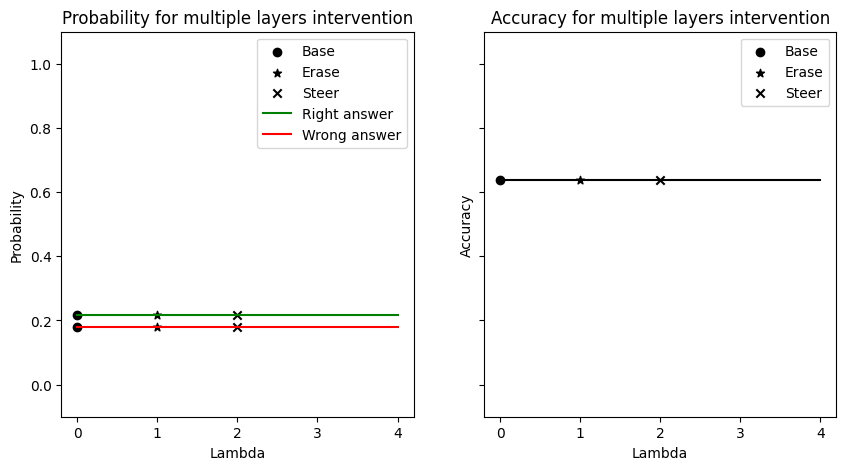

In [16]:
# Plots the graphs depending if we intervene in the attention or not.
# proba has shape [experiments, binary, lbds]
probas, accs = score_mix
nb_exp = accs.shape[0]

fig, axes = plt.subplots(nb_exp, 2, figsize=(10, 5*nb_exp), sharex = True, sharey = True)

for i, (proba, acc) in enumerate(zip(probas, accs)):
    if nb_exp ==1:
        a0 = axes[0]
        a1 = axes[1]
    else:
        a0 = axes[i, 0]
        a1 = axes[i, 1]
    a0.scatter([0, 0], [proba[0][0], proba[1][0]], color = "k", label = 'Base')
    a0.scatter([1, 1], [proba[0][10], proba[1][10]], color = 'k', label = 'Erase', marker = "*")
    a0.scatter([2, 2], [proba[0][20], proba[1][20]], color = 'k', label = 'Steer', marker = "x")
    a0.plot(lbds, proba[0], color = 'green', label = "Right answer")
    a0.plot(lbds, proba[1], color = 'red', label = "Wrong answer")

    a0.legend()
    a0.set_title("Probability for multiple layers intervention")
    a0.set_xlabel("Lambda")
    a0.set_ylabel("Probability")
    a0.set_ylim(-0.1, 1.1)

    a1.scatter([0], [acc[0]], color = "k", label = 'Base')
    a1.scatter([1], [acc[10]], color = 'k', label = 'Erase', marker = "*")
    a1.scatter([2], [acc[20]], color = 'k', label = 'Steer', marker = "x")
    a1.plot(lbds, acc, color = 'black')
    a1.set_xlabel("Lambda")
    a1.set_title("Accuracy for multiple layers intervention")
    a1.set_ylabel("Accuracy")
    a1.legend()

In [17]:
# If the code is interrupted while a hook is running, this will reset back the model to normal.
for module in model.transformer.h:
  module._forward_pre_hooks.clear()
  module.attn._forward_pre_hooks.clear()
  module.attn._forward_hooks.clear()

# Continuation Modification

We test here the modification of the sentence at inference time. \
Given a sentence, and words to intervene on, we look at continutations to see if there is any effect or not. \

In [18]:
# We compute all of the leace fitters and erasers
nb_layers = len(model.transformer.h)
layer_list = [[i for i in range(0, nb_layers)]]
layer_res_list = [[]]
lbds = t.tensor([i/10 for i in range(0, 41, 1)], dtype=t.float)

res_needed = len(layer_res_list[0]) > 0

Learn = dataset.get_ex('learn', multi_dim=True)

# Learning the estimators in the residual stream
flag = True
if flag:
  eraser_mean, eraser_quantile, _ = store_test_hyperplane.storing_hyperplanes(Learn, post_layer_norm=True, learn_probe=False, **dict)
  flag = False

if res_needed:
    eraser_mean_res, eraser_quantile_res, _ = store_test_hyperplane.storing_hyperplanes(Learn, post_layer_norm=False, learn_probe=False, **dict)
else:
    eraser_mean_res, eraser_quantile_res = None, None

NameError: name 'store_test_hyperplane' is not defined

In [ ]:
sentences : list[list[str]] = [["He is so pretty, I want to ask"]]
targets : list[list[str]] = [['He']]
layer_list : list[list[int]] = [[i for i in range(0, 48)]]
layer_res_list : list[list[int]] = [[]]
lbds = [0, 1, 2]
nb_seq = 5
max_len = 20
temp = 0.3

continuations = continuate(sentences, 
                      targets, 
                      eraser_mean,
                      eraser_mean_res,
                      layer_list,
                      layer_res_list,
                      lbds, 
                      nb_seq=nb_seq,
                      max_len=max_len, 
                      temp=temp,
                      **dict)

print(continuations)

Batch 0.


100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

[[['He is so pretty, I want to ask you a few questions.\n\nQ: What is your favorite part of the game?\n\n', 'He is so pretty, I want to ask my mom," she said.\n\n"I\'m so happy that she\'s here," said her', 'He is so pretty, I want to ask you about her."\n\n"I am sorry, but I\'m not sure she\'s ready for', "He is so pretty, I want to ask you a question. I think you're a little bit of a fool. You've been doing this", 'He is so pretty, I want to ask you, what is your favorite part about being a mother?\n\nI love being a mother.']]]
